In [1]:
%load_ext autoreload
%load_ext tensorboard

In [2]:
import os
import pickle
import datetime
import sys
sys.path.append('..')

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

from lib.cube import Cube
from lib.solver import CubeSolver
from lib.models import CNN
from lib.utils import linear_decay_constant, exponential_decay, constant_rate


%autoreload
%matplotlib inline

### Define experiment parameters

In [3]:
now = datetime.datetime.now().strftime("%Y%d%d%H%M%S")
session_name = 'base_model_v2_{}'.format(now)


logs_base_dir = "../logs/"
config_save_path = os.path.join(logs_base_dir,
                                'configs',
                                session_name + '.pickle')


config = {}

config['model_params'] = {'embed_dim':50,
                          'num_filters':20,
                          'num_conv_layers':1,
                          'kernel_size':2,
                          'regularization_constant':0,
                          'num_dense_layers':1,
                           'dense_activation':'elu'}

config['training_params'] = {'exploration_rate_func':linear_decay_constant,
                             'num_shuffles':2,
                             'num_episodes':1000,
                             'max_time_steps':5,
                             'epsilon':.1,
                             'decay_constant':100,
                             'end_state_reward':1,
                             'replay_buffer_capacity':128,
                             'learning_rate':.001,
                             'clipnorm':0,
                             'batch_size':16,
                             'discount_factor':.9,
                             'validation_count':100,
                             'train_log_name':session_name,
                             'stop_on_solve':True}

#### Visualize exploration strategy

Buffer fills in at most 25.6 episodes


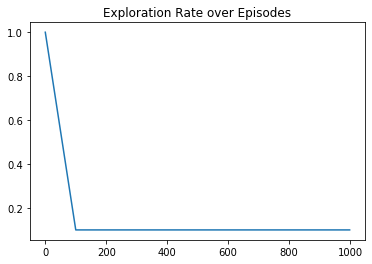

In [4]:
num_episodes = config['training_params']['num_episodes']
epsilon = config['training_params']['epsilon']
decay_constant = config['training_params']['decay_constant']
exploration_rate_func = config['training_params']['exploration_rate_func']
replay_buffer_capacity = config['training_params']['replay_buffer_capacity']
max_time_steps = config['training_params']['max_time_steps']
x = range(num_episodes)
y = [exploration_rate_func(epsilon, decay_constant, episode) for episode in x]
plt.plot(x,y)
plt.title("Exploration Rate over Episodes")
print("Buffer fills in at most {} episodes".format(replay_buffer_capacity/max_time_steps))

In [5]:
%tensorboard --logdir {logs_base_dir}

### Run Experiment + Save Results

In [6]:
solver = CubeSolver()
solver.model = CNN(**config['model_params'])
solver.train(**config['training_params'])
solver.save_model_weights(weights_dir_name=session_name)
with open(config_save_path ,'wb') as f:
    pickle.dump(config, f)

In [11]:
test_cube = Cube()
num_shuffles = config['training_params']['num_shuffles']
max_time_steps = config['training_params']['max_time_steps']
test_cube.shuffle(num_shuffles, verbose = True)
print()
solver.solve(test_cube, max_time_steps, verbose = True)

<bound method Cube.down of <lib.cube.Cube object at 0x1272100f0>>
<bound method Cube.front of <lib.cube.Cube object at 0x1272100f0>>

<bound method Cube.up of <lib.cube.Cube object at 0x1272100f0>>
<bound method Cube.down_p of <lib.cube.Cube object at 0x1272100f0>>
<bound method Cube.left_p of <lib.cube.Cube object at 0x1272100f0>>
<bound method Cube.up_p of <lib.cube.Cube object at 0x1272100f0>>
<bound method Cube.front of <lib.cube.Cube object at 0x1272100f0>>


(False,
 ['up', 'down_p', 'left_p', 'up_p', 'front'])

## Notes

base model can solve one shuffle
struggles with 3 shuffles, bigger capacity helps
also looks like more training helps, chopy val acc also

dying relu? shown by q value gradient_tape/base_model_v2_increased_dims_three_shuffle/train
switch to elu "gradient_tape/base_model_v2_increased_dims_v2/train"
gradient_tape/base_model_v2_20190909234830/train same as ^ but 2000 episode, 200 delay constant
gradient_tape/base_model_v2_20190909235656/train increase capacity and overfits
gradient_tape/base_model_v2_20191010000732/train overfitting shown clearly here

https://arxiv.org/abs/1511.07289

### Sandbox

In [ ]:
with open('../logs/configs/base_model_three_shuffle_increased_capacity_longer_training.pickle','rb') as f:
    old_params = pickle.load(f)
old_params